In [6]:
library(statsecol)
library(jagsUI)
library(MCMCvis)
library(ggplot2)

Warning message:
“package ‘jagsUI’ was built under R version 4.1.1”
Warning message:
“package ‘ggplot2’ was built under R version 4.1.1”


We will start by simulating data, then fitting a model to that data to demonstrate that the model can sufficiently recover the data generating values (see Chapter 13 of Kéry & Schaub (2012)). Consider a study of Asp viper (Vipera aspis) habitat patches. In this study, $M$ habitat patches are surveyed in $T$ years (primary sampling periods), and in each year, habitat patches were visited/surveyed $J$ times (secondary sampling periods). Remember that the closure assumption asserts that the occupancy state does not change between the secondary visits but can change from one year to the next. The data arising from these surveys are summarised as $y_{i,j,k}$ - the imperfect detection $(y=1)$ or not $(y=0)$ of evidence of patch $i$ being occupied in the $j^{th}$ survey in year $k$. We analyse the patch-by-year encounter histories using the following state-space model.

We estimate the initial patch states as Bernoulli random variables:
$$z_{i,1} \sim Bernoulli(\psi_{1})$$,
and subsequent occupancy states as being conditional on the previous state:
$$z_{i,t}|z_{i,t−1}∼Bernoulli(\psi_{i,t})$$
$$\psi_{i, t} =(1−z_{i,t−1})\gamma + z_{i,t−1}(1−\epsilon)$$

$\epsilon$ - probability to go extinct

$\gamma$ - probability to be colonized

This is the model for the dynamics of the true but imperfectly observed occupancy states. We link this model to the observations (y) via an observation model which assumes that detection is imperfect and conditional on the underlying occupancy state. Here we will assume that detection probability is constant over the the J secondary visits and treat them as binomial random variables with a trial size of J:

$$y_{i,t}|z_{i,t} \sim binomial(J_{i},p_{i,t}z_{i,t})$$

Notice that the detection probability of an empty site (i.e., $z=0$) is $p_{i,t}z_{i,t}$)=0, and when a site is occupied it is p_{i,t}z_{i,t})=p. Here, J is the number of visits to site $i$.

This model description defines the full likelihood of the state-space formulation of a dynamic occupancy model. Next we will simulate some data and then conduct a Bayesian analysis of the model fitted to the simulated data.


Let’s simulate asp viper patch occupancy dynamics and corresponding observation data using the following parameter values:

| Description                | Parameter                  | Value    |
|:--------------------------:|:--------------------------:|:--------:|
|Number of patches|M| 75|
|Primary periods (years)|T|10.00|
|Secondary periods (visits)|J|2.00|
|Initial occupancy probability|$\psi_{1}$|0.70|
|Colonisation probability|$\gamma$|0.05|
|Extinction probability|$\epsilon$|0.10|
|Detection probability|$p$|0.25|



In [2]:
n.sites <- 75   # M
n.years <- 10   # T
n.visits <- 2   # J

#model parameters
psi1 <- 0.7
gamma <- 0.05
epsilon <- 0.1
p <- 0.25

#storage objects
z <- array(NA, dim=c(n.sites, n.years)) # M x T 
y <- array(NA, dim=c(n.sites, n.years)) # M x T

#initial states
z[,1] <- rbinom(n=n.sites, size = 1, prob = psi1) # Initial sites z are occupied with probability psi1

#subsequent states
for(t in 2:n.years){
  expected.psi <- (1-z[, t-1])*gamma + z[, t-1]*(1-epsilon) 
  z[, t] <- rbinom(n=n.sites, size = 1, prob = expected.psi) 
}

#detection-nondetection data
for(t in 1:n.years){
  y[,t] <- rbinom(n=n.sites, size = n.visits, p*z[,t])
}

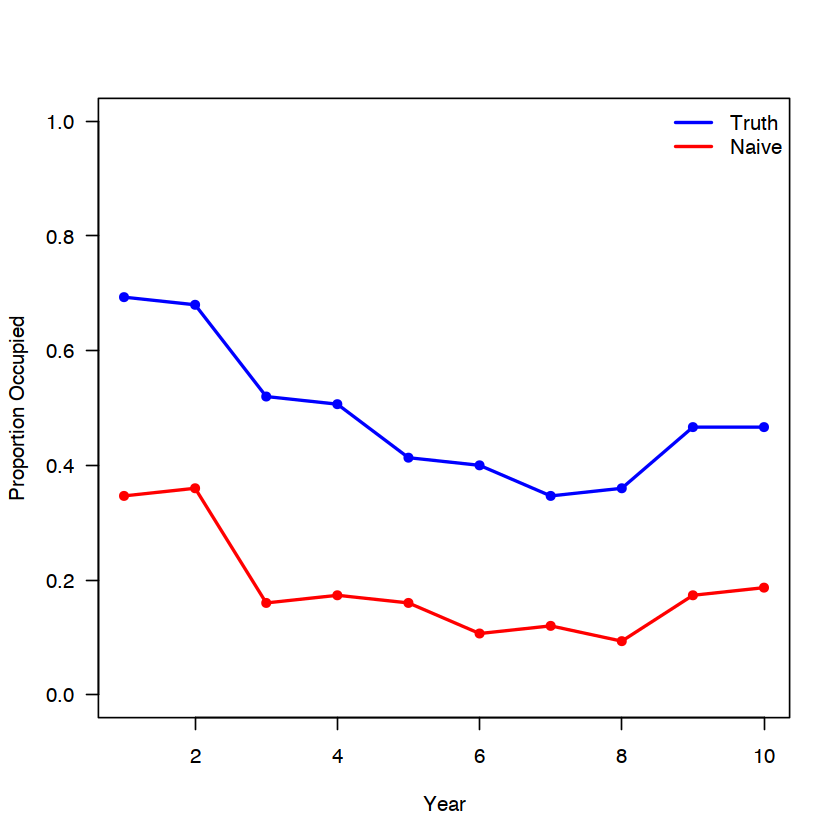

In [3]:
true.occ <- apply(z,2,mean)
naive.occ <- apply(y>0,2,mean)
years <- 1:n.years
plot(true.occ ~ years, lwd=2, col="blue", las = 1, ylim=c(0,1), 
     ylab="Proportion Occupied", xlab = "Year", type="o",pch=16)
lines(naive.occ ~ years, lwd=2, col="red",type="o",pch=16)
legend("topright",c("Truth","Naive"), lwd=2, col=c("blue","red"), bty="n")

- What are the parameters of this model?
- What are appropriate priors for these parameters?


$$\psi \sim Uniform(0, 1)$$
$$\gamma \sim Uniform(0, 1)$$
$$\epsilon \sim Uniform(0, 1)$$
$$p \sim Uniform(0, 1)$$

In [ ]:
# Specify model in BUGS language
sink("viperSSM.txt")
cat("
model{
    # Priors and constraints
    psi1 ~ dunif(0, 1)
    gamma ~ dunif(0, 1)
    epsilon ~ dunif(0, 1)
    p ~ dunif(0, 1)


  # Likelihood - State process
  for(i in 1:n.sites){
    z[i, 1] ~ dbinom(psi1, 1)
    for(t in 2:n.years){ #subsequent        
        z[i, t] ~ dbern((1 - z[i, t-1])*gamma + z[i, t-1] * (1 - epsilon))
    }
  }
  
  # Likelihood - Observation process
  for(i in 1:n.sites){
    for(t in 1:n.years){
        y[i, t] ~ dbin(p * z[i, t], n.visits)

        yobs[i,t] <- y[i,t]                                   #unneccessary, but for completeness
        ysim[i,t] ~ dbin(p*z[i,t],n.visits)                   #simulate new counts from the model
        yexp[i,t] <- p*n.visits*z[i,t] +0.001                 #expected counts under the model
      
        # Observation level discrepency: [(o - e)^2 / e]
        disc.obs[i,t] <- pow((yobs[i,t] - yexp[i,t]),2)/(yexp[i,t]) # for observed data
        disc.sim[i,t] <- pow((ysim[i,t] - yexp[i,t]),2)/(yexp[i,t]) # for 'ideal' data
    }
  }

  chi2.obs <- sum(disc.obs[,])
  chi2.sim <- sum(disc.sim[,])
  chi2.ratio <- chi2.obs/chi2.sim
  
  # Derived quantities
  for(t in 1:n.years){
    # out of all the sites, what is the 
    # proportion of sites occupied
    propocc[t] <- sum(z[,t])/n.sites
  }
}
",fill = TRUE)
sink()

In [24]:
# Bundle the data
viperdata <- list(
    n.sites = n.sites,
    n.years = n.years,
    n.visits = n.visits,
    y = y
)

# Initial values function
viperinits <- function(){
  list(
    psi1 = runif(1,0,1),
    gamma = runif(1,0,1),
    epsilon = runif(1,0,1),
    z = ifelse(y>0,1,0)) 
}

# Parameters to monitor
viperparms <- c("psi1","gamma","epsilon","p","propocc", "chi2.obs","chi2.sim","chi2.ratio")

# MCMC settings
nc <- 3
nb <- 1000
ni <- 5000 + nb
nt <- 1

In [25]:
viperout <- jags(
    data = viperdata,
    inits = viperinits,
    parameters.to.save = viperparms,
    model.file = "viperssm.txt",
    n.chains = nc,
    n.iter = ni,
    n.burnin = nb,
    n.thin = nt
)


Processing function input....... 

Done. 
 
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 750
   Unobserved stochastic nodes: 1504
   Total graph size: 11747

Initializing model

Adaptive phase..... 
Adaptive phase complete 
 

 Burn-in phase, 1000 iterations x 3 chains 
 

Sampling from joint posterior, 5000 iterations x 3 chains 
 

Calculating statistics....... 

Done. 


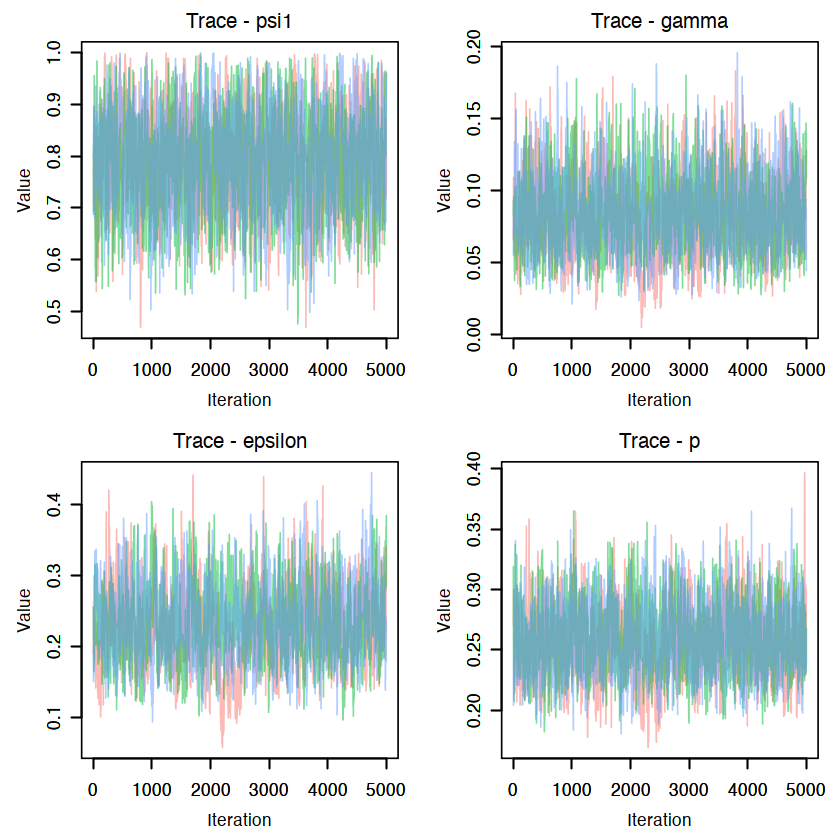

In [26]:
MCMCtrace(viperout,                
          params = viperparms[1:4],
          type = "trace",
          iter = ni,  
          pdf = FALSE)

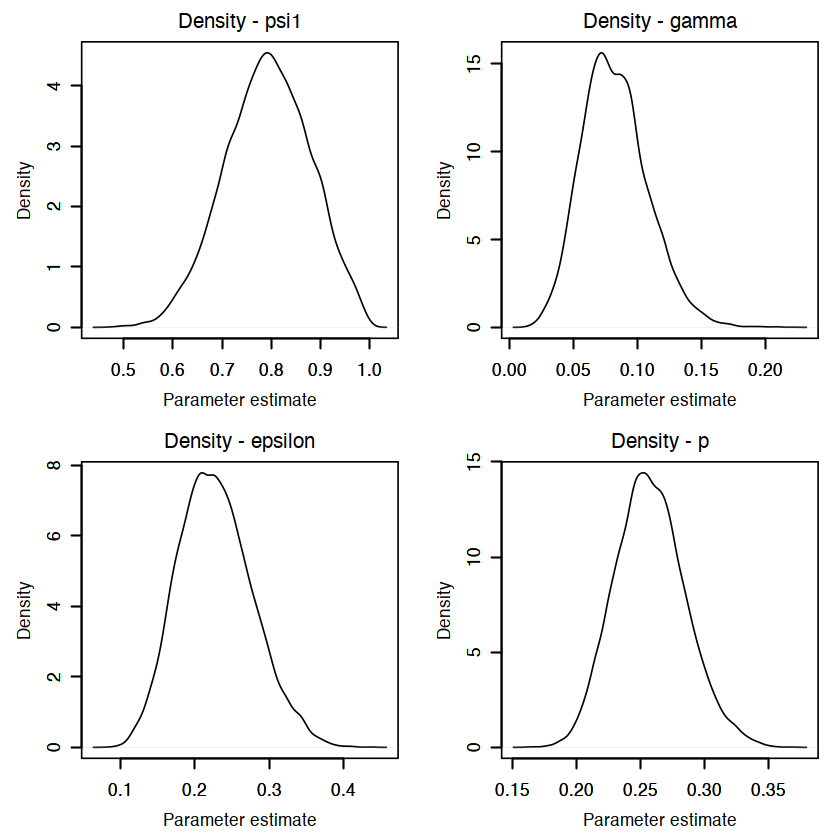

In [17]:
MCMCtrace(viperout,                
          params = viperparms[1:4],
          type = "density", 
          iter = ni,  
          pdf = FALSE,
          ind = FALSE)

In [18]:
MCMCsummary(viperout,
            params = viperparms[1:4],
            digits = 2)

,mean,sd,2.5%,50%,97.5%,Rhat,n.eff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
psi1,0.790,0.086,0.620,0.790,0.95,1.00,15000
gamma,0.083,0.026,0.038,0.081,0.14,1.01,370
epsilon,0.230,0.050,0.140,0.230,0.33,1.01,333
p,0.260,0.028,0.210,0.260,0.32,1.00,739


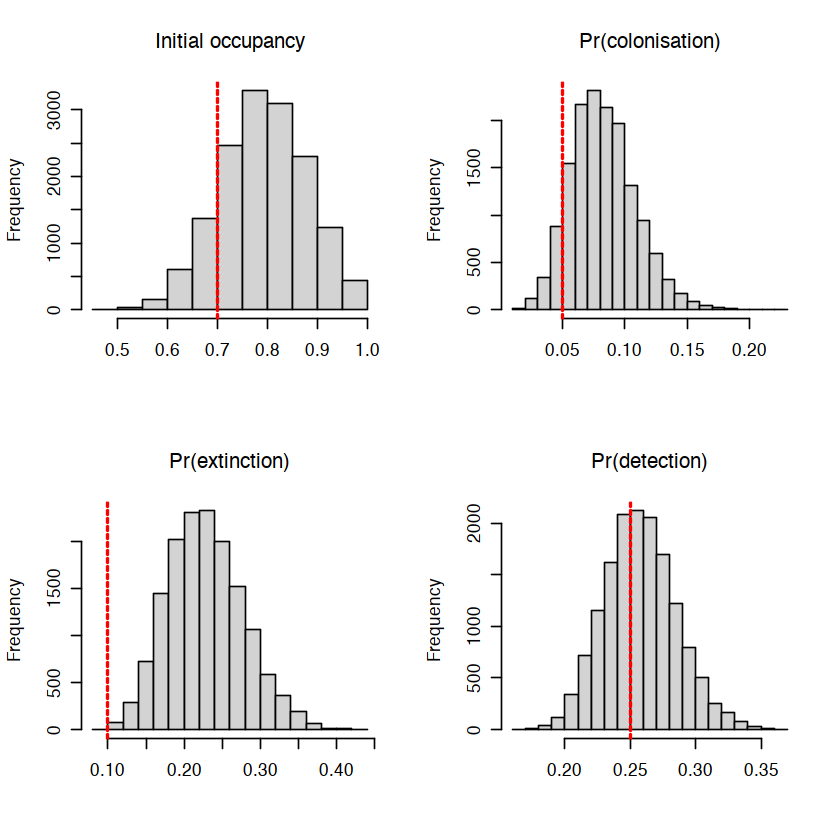

In [19]:
par(mfrow=c(2,2))
hist(viperout$sims.list$psi1, main="Initial occupancy", xlab=" ")    
abline(v=psi1, col="red", lwd=2, lty=2)
hist(viperout$sims.list$gamma, main="Pr(colonisation)", xlab=" ")
abline(v=gamma, col="red", lwd=2, lty=2)
hist(viperout$sims.list$epsilon, main="Pr(extinction)", xlab=" ")
abline(v=epsilon, col="red", lwd=2, lty=2)
hist(viperout$sims.list$p, main="Pr(detection)", xlab=" ")
abline(v=p, col="red", lwd=2, lty=2)

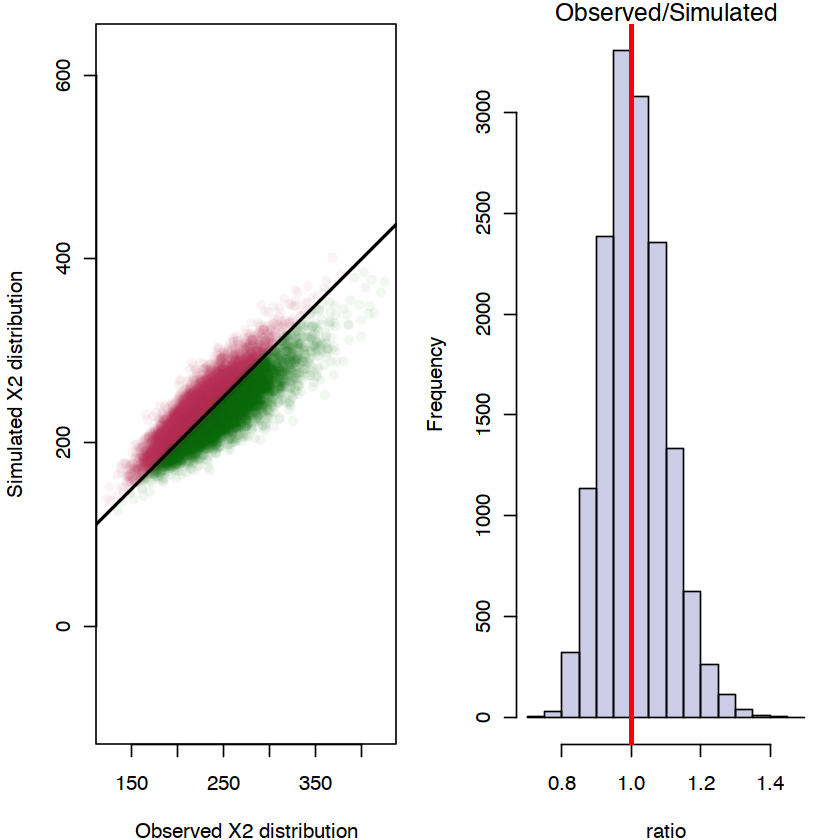

In [29]:
obs <- viperout$sims.list$chi2.obs
sim <- viperout$sims.list$chi2.sim
ratio <- viperout$sims.list$chi2.ratio

par(mfrow=c(1,2), oma=c(0,0,0,0), mar=c(4,4,1,1))
plot(sim~obs,col=adjustcolor(ifelse(ratio<1, "maroon","darkgreen"),0.05), pch=16, asp=1, 
     xlab="Observed X2 distribution", ylab="Simulated X2 distribution")
abline(0,1, lwd=2)

hist(ratio, col=adjustcolor("darkblue",0.2), main="Observed/Simulated")
abline(v=1, lwd=3, col="red")

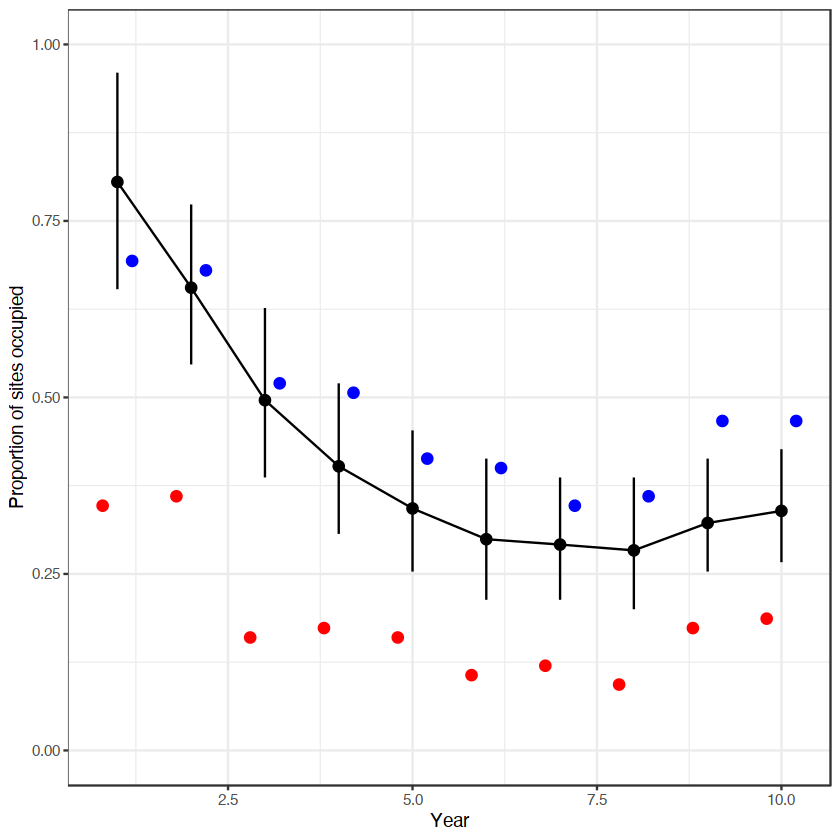

In [13]:
occ_df <- data.frame(Year = 1:n.years,
                     Mean = viperout$mean$propocc,
                     Lower = viperout$q2.5$propocc,
                     Upper = viperout$q97.5$propocc,
                     Naive = apply(y>0,2,sum)/n.sites,
                     Truth = apply(z,2,sum)/n.sites)
ggplot(data=occ_df) +
  geom_errorbar(aes(x=Year, y=Mean, ymin=Lower, ymax = Upper, width=0)) + 
  geom_line(aes(x=Year, y=Mean)) +
  geom_point(aes(x=Year, y=Mean), size=2.5) +
  geom_point(aes(x=Year-0.2, y=Naive), color="red",size=2.5) +
  geom_point(aes(x=Year+0.2, y=Truth), color="blue",size=2.5) +
  ylab("Proportion of sites occupied") + ylim(0,1) + theme_bw()